In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/aoml-m-2-test-feb-2025/sample_submission.csv
/kaggle/input/aoml-m-2-test-feb-2025/train.csv
/kaggle/input/aoml-m-2-test-feb-2025/test.csv


In [5]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestRegressor
from sklearn.feature_selection import RFE
from sklearn.linear_model import Lasso
from sklearn.metrics import mean_squared_error
df = pd.read_csv('/kaggle/input/aoml-m-2-test-feb-2025/train.csv')  # adjust the path if needed

# Check for missing values
print("Missing values before imputation:")
print(df.isnull().sum())

# Ensure 'day' column is a string or categorical type
df['day'] = df['day'].astype(str)  # Ensure it's treated as a string

# 1. Impute missing values in categorical columns (if any)
imputer_cat = SimpleImputer(strategy='most_frequent')
df['day'] = imputer_cat.fit_transform(df[['day']]).ravel()


# 2. One-hot encode the 'day' column (creating separate columns for each day)
df = pd.get_dummies(df, columns=['day'], drop_first=True)

# 3. Impute missing values in numerical columns with median
num_cols = df.select_dtypes(include='number').columns
df[num_cols] = df[num_cols].fillna(df[num_cols].median())

# Check the updated columns
print("Updated Columns after imputation:")
print(df.columns)

Missing values before imputation:
uid                                 0
day                              5479
hour                             5613
minute                           5470
C_motion                         5517
feed_water_motion                5597
faucet_hole                      5566
vapour_pressure                  5479
vapour_enthalpy                  5437
vapour_pressure_at_division      5477
vapour_motion                    5477
feed_water_enth                  5496
vapour_temperature               5517
output_electricity_generation       0
dtype: int64
Updated Columns after imputation:
Index(['uid', 'hour', 'minute', 'C_motion', 'feed_water_motion', 'faucet_hole',
       'vapour_pressure', 'vapour_enthalpy', 'vapour_pressure_at_division',
       'vapour_motion', 'feed_water_enth', 'vapour_temperature',
       'output_electricity_generation', 'day_Saturday', 'day_nan'],
      dtype='object')


In [8]:
# 4. Train-test split
X = df.drop(columns=['output_electricity_generation'])
y = df['output_electricity_generation']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [9]:
# 5. Feature Scaling
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


In [10]:
# 6. Apply Recursive Feature Elimination (RFE) with RandomForestRegressor
model = RandomForestRegressor(n_estimators=100)
selector = RFE(model, n_features_to_select=10)  # Select top 10 features
X_rfe = selector.fit_transform(X_train_scaled, y_train)

# Print selected features from RFE
selected_features = X.columns[selector.support_]
print("Selected Features from RFE:", selected_features)


Selected Features from RFE: Index(['hour', 'C_motion', 'feed_water_motion', 'faucet_hole',
       'vapour_pressure', 'vapour_enthalpy', 'vapour_pressure_at_division',
       'vapour_motion', 'feed_water_enth', 'vapour_temperature'],
      dtype='object')


In [11]:
# 7. Apply Lasso Regression (L1 Regularization) for feature selection
lasso = Lasso(alpha=0.01)
lasso.fit(X_train_scaled, y_train)

# Print important features from Lasso
important_features_lasso = X.columns[lasso.coef_ != 0]
print("Important Features from Lasso:", important_features_lasso)


Important Features from Lasso: Index(['uid', 'hour', 'minute', 'C_motion', 'feed_water_motion', 'faucet_hole',
       'vapour_pressure', 'vapour_enthalpy', 'vapour_pressure_at_division',
       'vapour_motion', 'feed_water_enth', 'vapour_temperature',
       'day_Saturday', 'day_nan'],
      dtype='object')


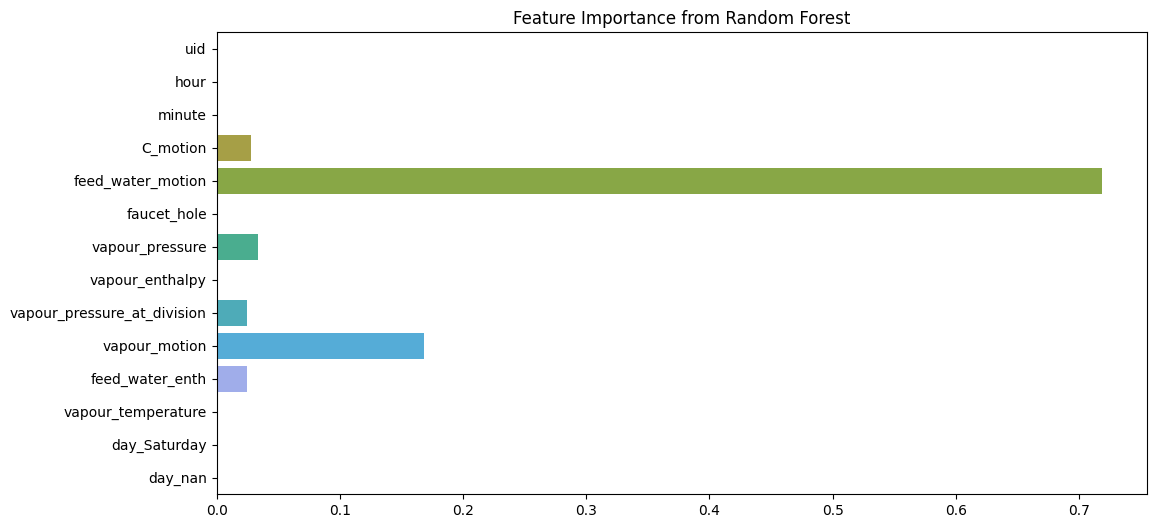

In [12]:
# 8. Apply Random Forest Feature Importance
rf = RandomForestRegressor(n_estimators=100)
rf.fit(X_train_scaled, y_train)

# Plot Feature Importance from Random Forest
importances = rf.feature_importances_
features = X.columns

plt.figure(figsize=(12, 6))
sns.barplot(x=importances, y=features)
plt.title("Feature Importance from Random Forest")
plt.show()



In [13]:
# 9. Train Random Forest model with selected features
rf_model = RandomForestRegressor(n_estimators=100)
rf_model.fit(X_train_scaled, y_train)



RandomForestRegressor()

In [14]:
# 10. Make predictions and evaluate the model
y_pred = rf_model.predict(X_test_scaled)
mse = mean_squared_error(y_test, y_pred)
print("Mean Squared Error of the Random Forest model:", mse)


Mean Squared Error of the Random Forest model: 6.59548092490899


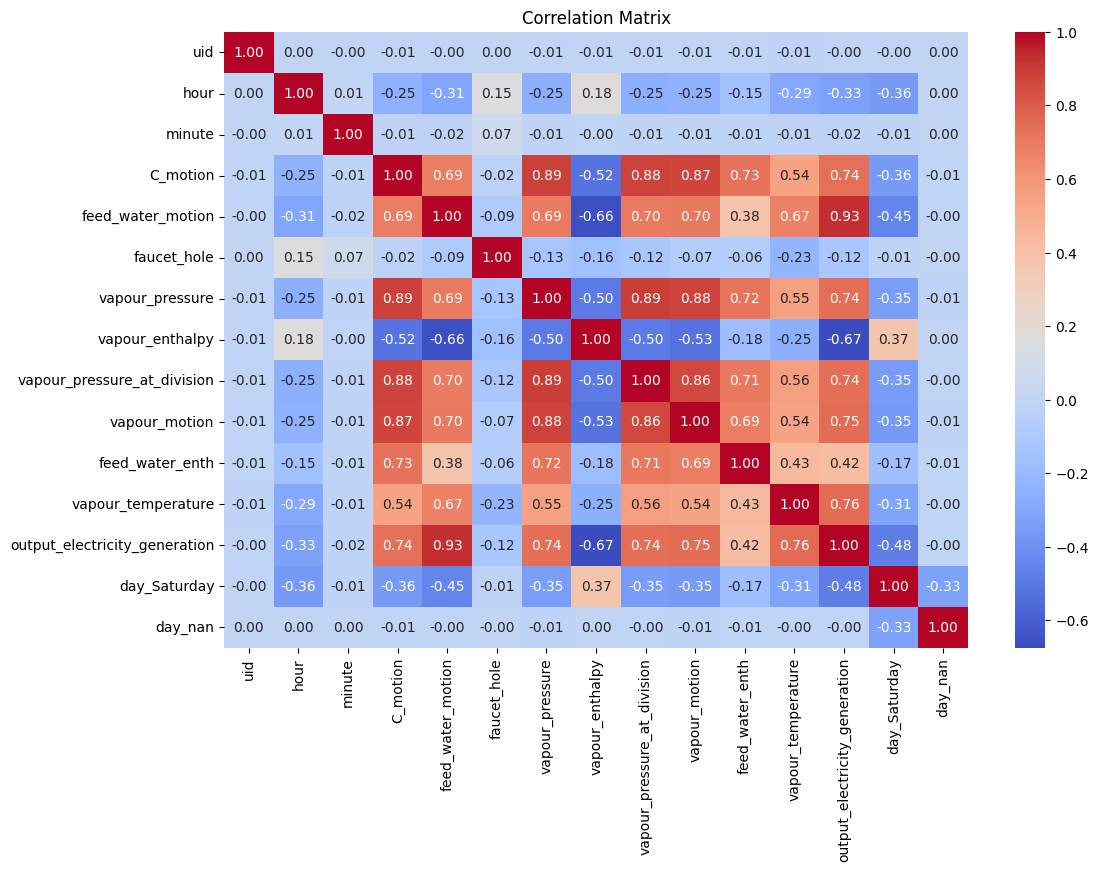

In [15]:
# 11. Correlation Heatmap (optional)
corr_matrix = df.corr()
plt.figure(figsize=(12, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt='.2f')
plt.title("Correlation Matrix")
plt.show()

In [16]:
# Check the columns in the dataset
print(df.columns)


Index(['uid', 'hour', 'minute', 'C_motion', 'feed_water_motion', 'faucet_hole',
       'vapour_pressure', 'vapour_enthalpy', 'vapour_pressure_at_division',
       'vapour_motion', 'feed_water_enth', 'vapour_temperature',
       'output_electricity_generation', 'day_Saturday', 'day_nan'],
      dtype='object')
